In [1]:
%matplotlib inline

# Search algoritms

## Define and visualize our map

In [2]:
cities = [
    ["Arad", 394, 580],
    ["Bucharest", 1780, 1332],
    ["Craiova", 1126, 1509],
    ["Dobreta", 726, 1452],
    ["Eforie", 2496, 1495],
    ["Fagaras", 1380, 796],
    ["Giurgiu", 1654, 1579],
    ["Hirsowa", 2368, 1239],
    ["Lasi", 2125, 540],
    ["Lugoj", 724, 1104],
    ["Mehadia", 742, 1275],
    ["Neamt", 1842, 391],
    ["Oradea", 589, 207],
    ["Pitesti", 1432, 1168],
    ["Rimnicu Vilcea", 1035,963],
    ["Sibiu", 924, 748],
    ["Timisoara", 411, 951],
    ["Urziceni", 2047, 1249],
    ["Vaslui", 2278, 826],
    ["Zerind", 471, 402]
];

connections = [
    ["Arad", "Zerind"],
    ["Arad", "Sibiu"],
    ["Arad", "Timisoara"],
    ["Zerind", "Oradea"],
    ["Oradea", "Sibiu"],
    ["Timisoara", "Lugoj"],
    ["Sibiu", "Fagaras"],
    ["Sibiu", "Rimnicu Vilcea"],
    ["Lugoj", "Mehadia"],
    ["Fagaras", "Bucharest"],
    ["Rimnicu Vilcea", "Pitesti"],
    ["Rimnicu Vilcea", "Craiova"],
    ["Mehadia", "Dobreta"],
    ["Bucharest", "Pitesti"],
    ["Bucharest", "Urziceni"],
    ["Bucharest", "Giurgiu"],
    ["Pitesti", "Craiova"],
    ["Craiova",  "Dobreta"],
    ["Urziceni", "Hirsowa"],
    ["Urziceni", "Vaslui"],
    ["Hirsowa", "Eforie"],
    ["Vaslui", "Lasi"],
    ["Lasi", "Neamt"]
];

In [3]:
def getCityLocation(cityName):
    return [c for c in cities if c[0] == cityName ][0]
getCityLocation("Arad")

['Arad', 394, 580]

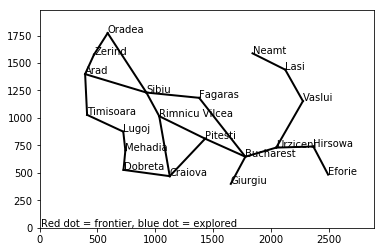

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
from copy import deepcopy

def visualizeMap(highlighted_citys = [], paths = [], size = 1):
    axes = plt.gca()
    xlim, ylim = max(cities, key=lambda x: x[1])[1]+400, max(cities, key=lambda x: x[2])[2]+400
    axes.set_xlim([0,xlim])
    axes.set_ylim([0,ylim])

    for con in connections:
        a = getCityLocation(con[0])
        b = getCityLocation(con[1])
        plt.plot([a[1], b[1]], [ylim-a[2], ylim-b[2]], 'k-', lw=2)

    for city in cities:
        plt.text(city[1], ylim-city[2], city[0], fontsize=10)

    for highlighted_city in highlighted_citys:
        location = getCityLocation(highlighted_city)
        plt.scatter(location[1], ylim-location[2], c="blue", s=50)
    
    city_offsets = {}
    for path in paths:
        score = path.combined_cost
        path = path.path + [path.location]
        if len(path) > 1:
            current = deepcopy(getCityLocation(path[0]))
            if current[0] not in city_offsets:
                city_offsets[current[0]] = 10
            city_offsets[current[0]] += 10
            current[2] += city_offsets[current[0]]
            
            for to in path[1:]:
                to = deepcopy(getCityLocation(to))
                
                if to[0] not in city_offsets:
                    city_offsets[to[0]] = 10
                city_offsets[to[0]] += 10
                to[2] += city_offsets[to[0]]
                
                plt.plot([current[1], to[1]], [ylim-current[2], ylim-to[2]], 'k-', lw=1, alpha=0.4)
                
                current = to
            plt.scatter(current[1], ylim-current[2]+city_offsets[current[0]], c="red", s=50)
            plt.text(current[1], ylim-current[2]-40, str(int(score)), fontsize=10)
    plt.text(10, 10, "Red dot = frontier, blue dot = explored")
            

    plt.rcParams["figure.figsize"] = [16,9]

    plt.show()

visualizeMap()


## Define helperfunction for the map problem

In [5]:
import numpy as np
import math
import random
from copy import deepcopy
from operator import attrgetter

In [6]:
def connections_from(city):
    connections_from_town = [c for c in connections if c[0] == city]
    connections_to_town = [c for c in connections if c[1] == city]
    
    all_connections = []
    for con in connections_from_town:
        all_connections += con
    for con in connections_to_town:
        all_connections += con
            
    cons = list(np.unique( all_connections ))
    cons.remove(city)
    return cons
    
print(connections_from("Arad"))
print(connections_from("Sibiu"))

['Sibiu', 'Timisoara', 'Zerind']
['Arad', 'Fagaras', 'Oradea', 'Rimnicu Vilcea']


In [7]:
def length_between(a, b):
    a = getCityLocation(a)
    b = getCityLocation(b)
    return math.sqrt((a[1]-b[1])**2 + (a[2]-b[2])**2)

print(length_between("Arad", "Sibiu"))

555.989208528367


## Helper function for a search algoritm

In [8]:
class path:
    def __init__(self, location, path=[]):
        self.location = location
        self.cost = 0
        self.cost_to_goal = 0
        self.path = path
    
    def go(self, location, cost):
        new_state = deepcopy(self)
        new_state.path.append(new_state.location)
        new_state.location = location
        new_state.cost += cost
        return new_state
    
    @property
    def combined_cost(self):
        return self.cost + self.cost_to_goal
    
    def __str__(self):
        if self.combined_cost == self.cost:
            return "->".join(self.path+[self.location]) + " cost: "+str(int(self.combined_cost)) 
        return "->".join(self.path+[self.location]) + " cost: "+str(int(self.combined_cost)) + " ("+str(int(self.cost))+")"

a = path("a")
a_b = a.go("b", 10)

print(a)
print(a_b)

a_b.cost_to_goal = 100
print(a_b.combined_cost)
print()

def min_objects(objects, key):
    min_value = float("inf")
    min_objects = []
    for obj in objects:
        value = getattr(obj, key)
        if value < min_value:
            min_value = value
            min_objects = [obj]
        elif value == min_value:
            min_objects.append(obj)
    return min_objects

print(str(len(min_objects([a,a,a_b], "cost")))+" should be 2")

def in_objects(objects, key, value):
    for obj in objects:
        if getattr(obj, key) == value:
            return obj
    return False
    
print(in_objects([path("a")],"location","b"))
print(in_objects([path("a")],"location","a"))

a cost: 0
a->b cost: 10
110

2 should be 2
False
a cost: 0


## Algoritms
#### Breadth first search

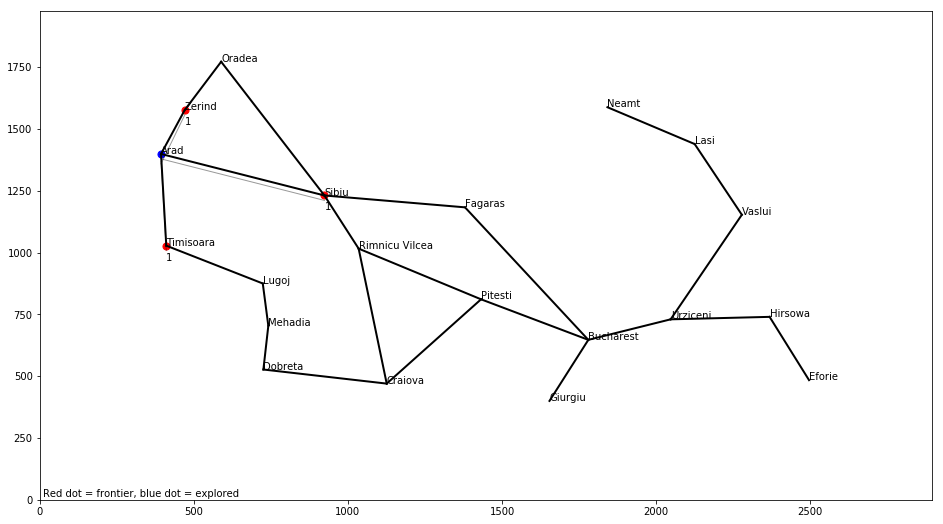

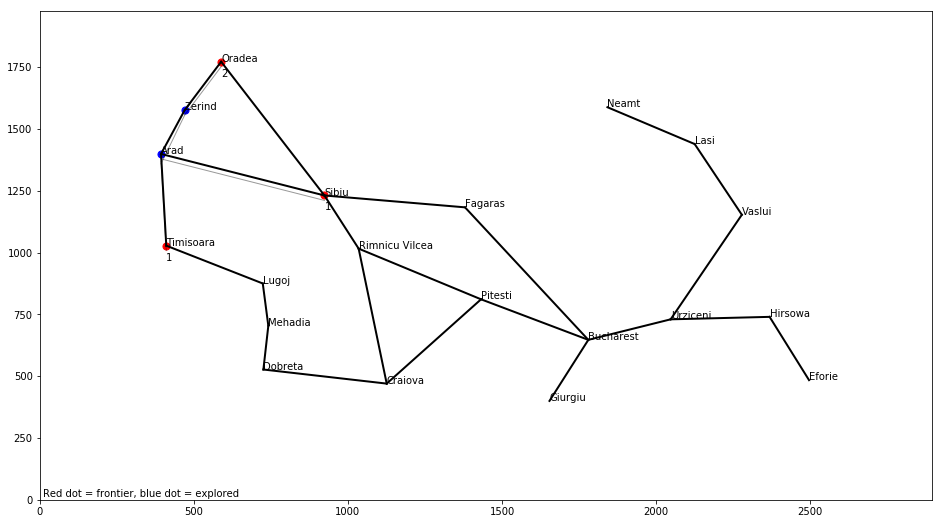

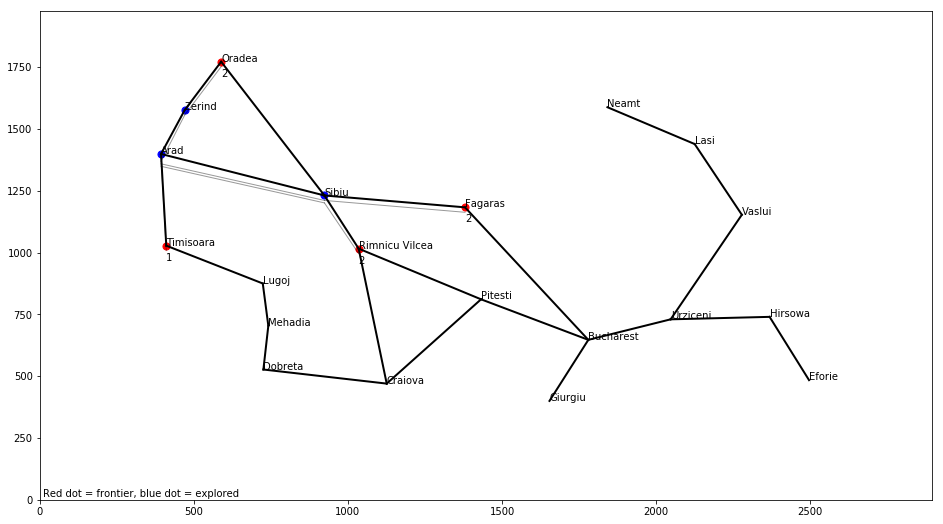

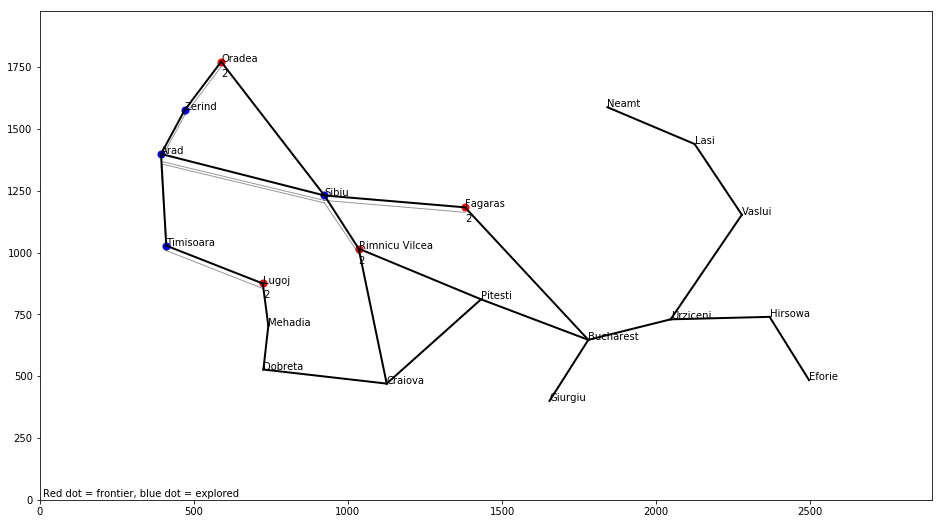

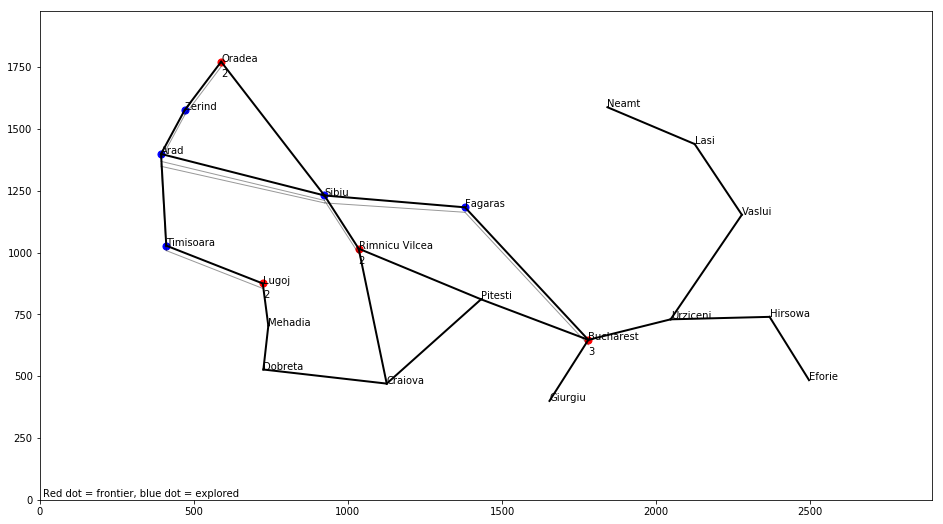

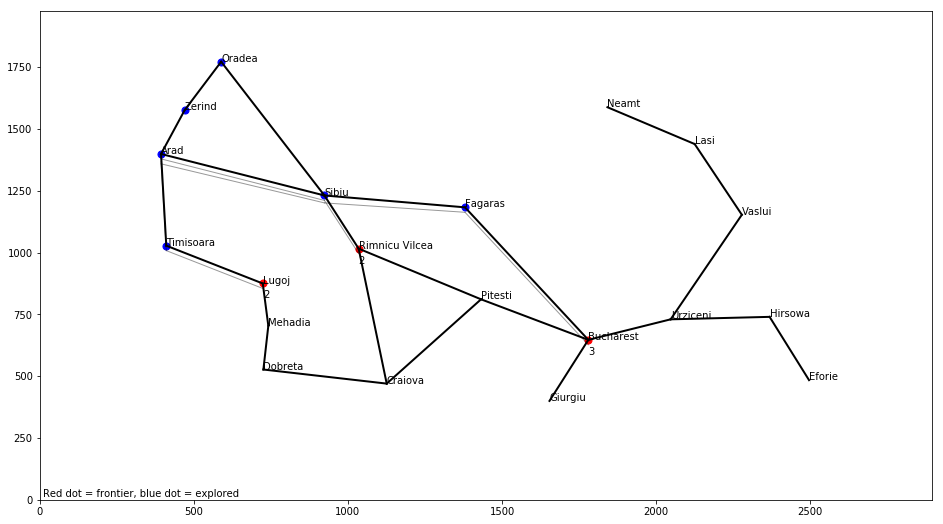

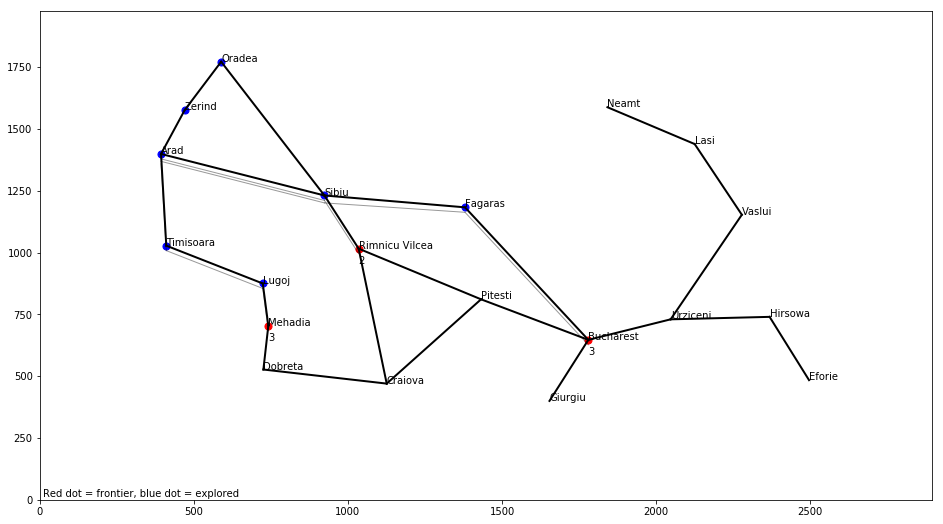

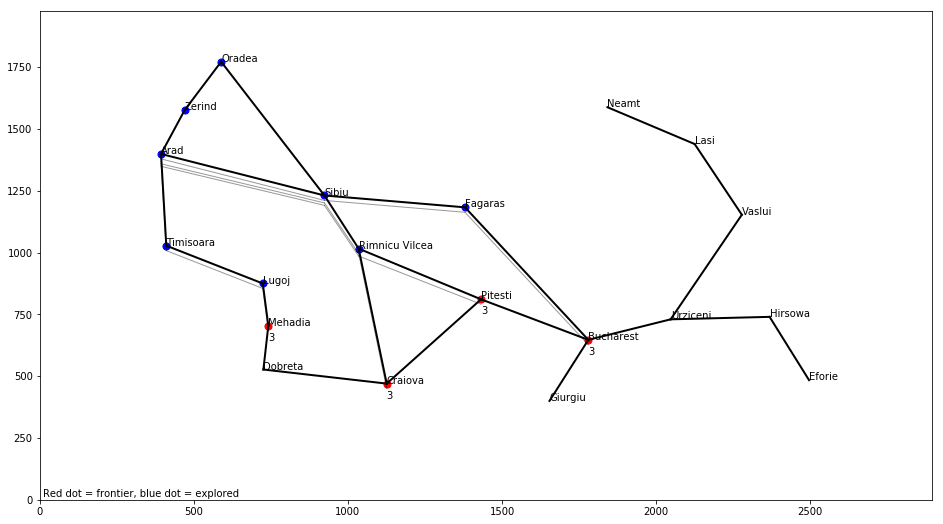

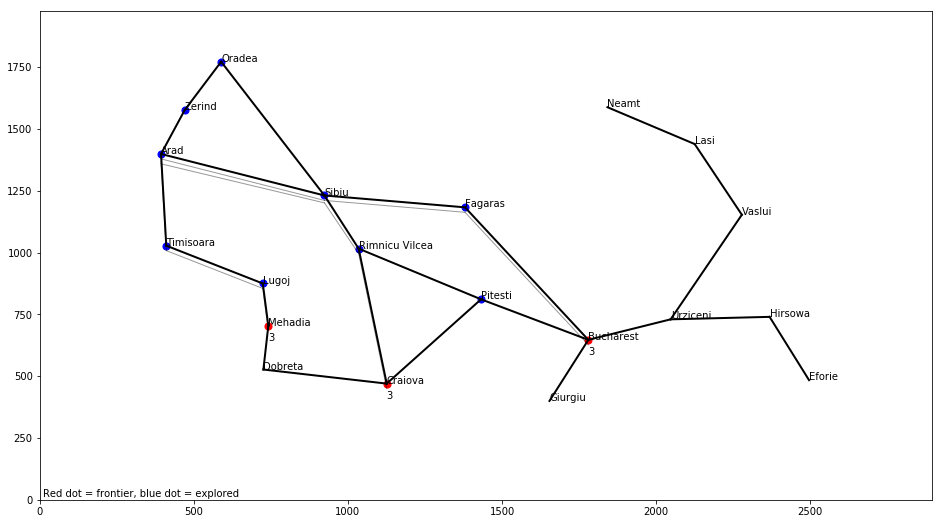

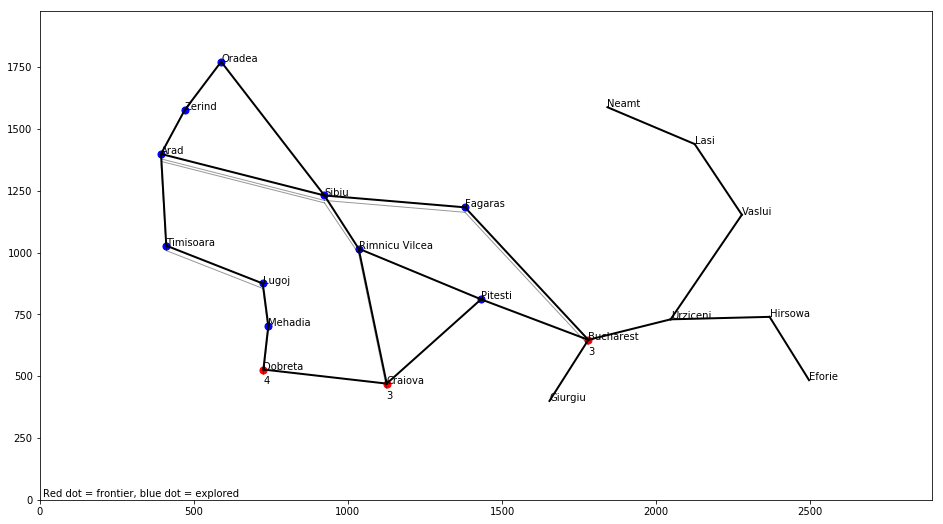

Arad->Sibiu->Fagaras->Bucharest cost: 3


In [9]:
def breadth_first_search(start, goal):
    global path
    frontier = [path(start)]
    explored = []
    while True:       
            
        if len(frontier) == 0:
            return False
        node = random.choice(min_objects(frontier, "cost"))
        if node.location == goal:
            return node
        
        frontier.remove(node)
        explored.append(node.location)
       
        for new_location in connections_from(node.location):
            if new_location not in explored and in_objects(frontier, "location", new_location) == False:
                frontier.append(node.go(new_location, 1))
                
        visualizeMap(explored, frontier, 3)
    
print(breadth_first_search("Arad", "Bucharest"))
    

#### Uniform cost search

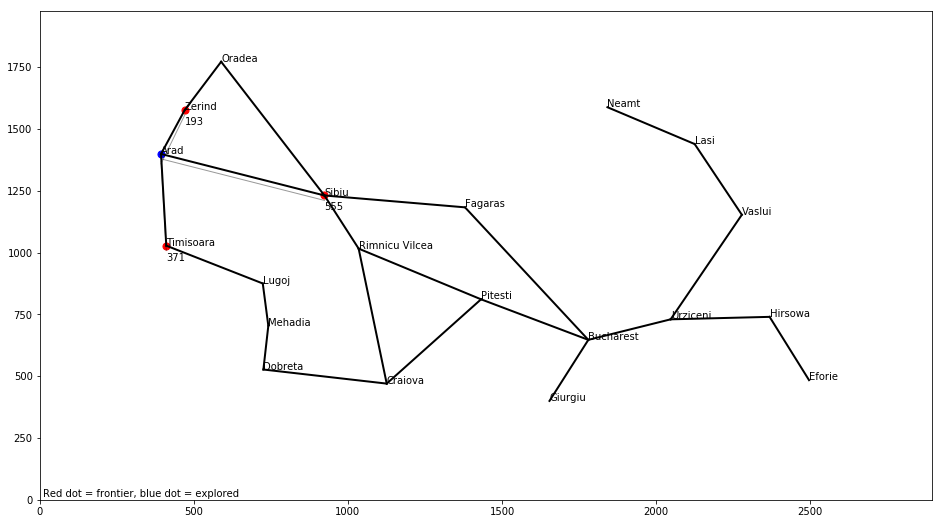

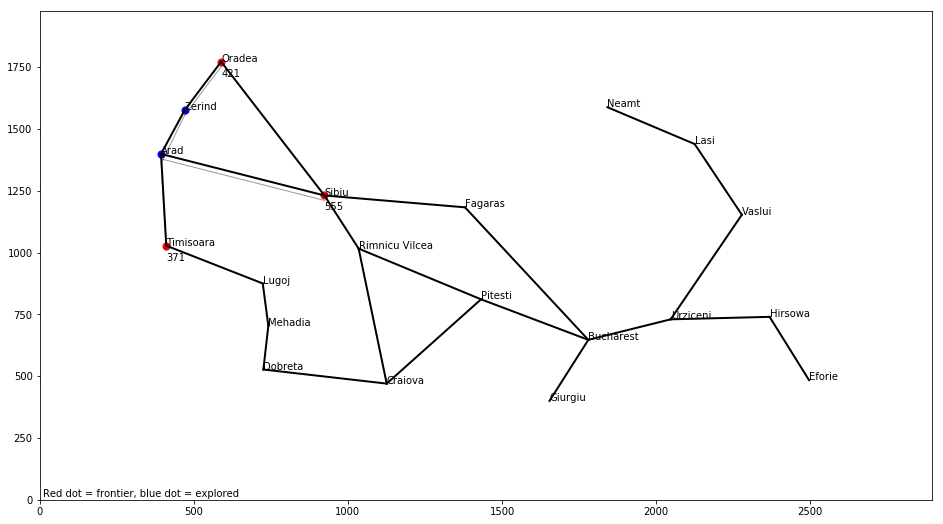

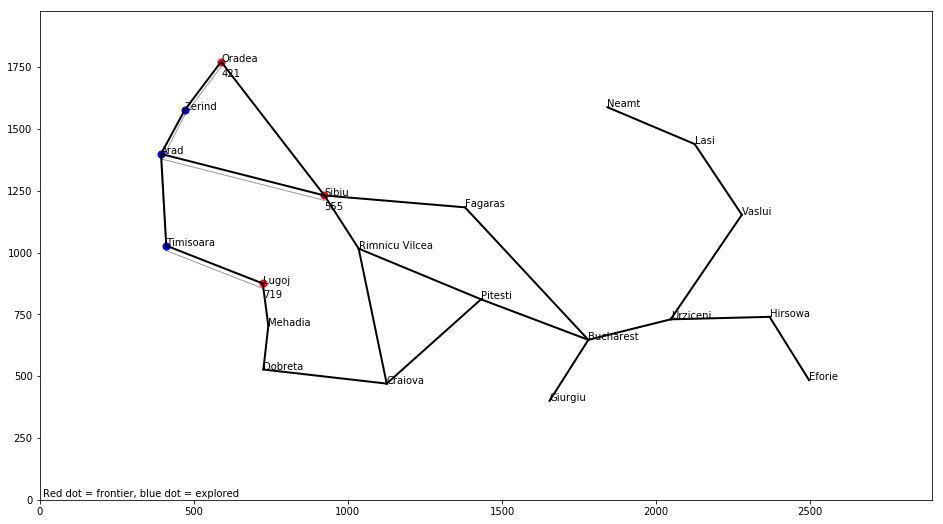

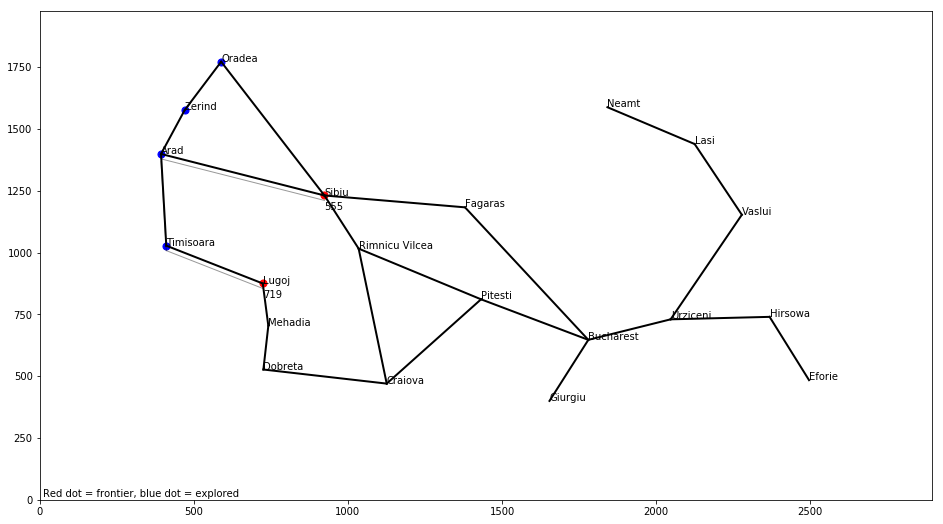

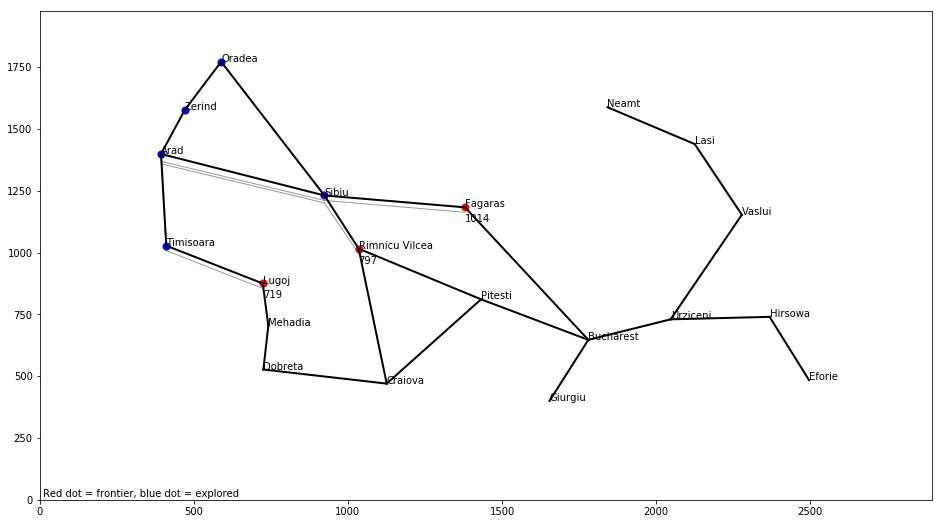

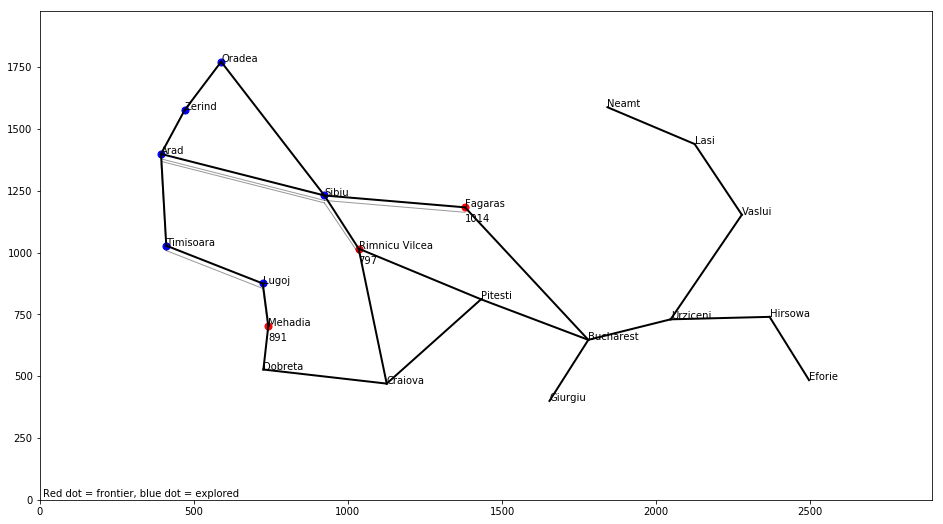

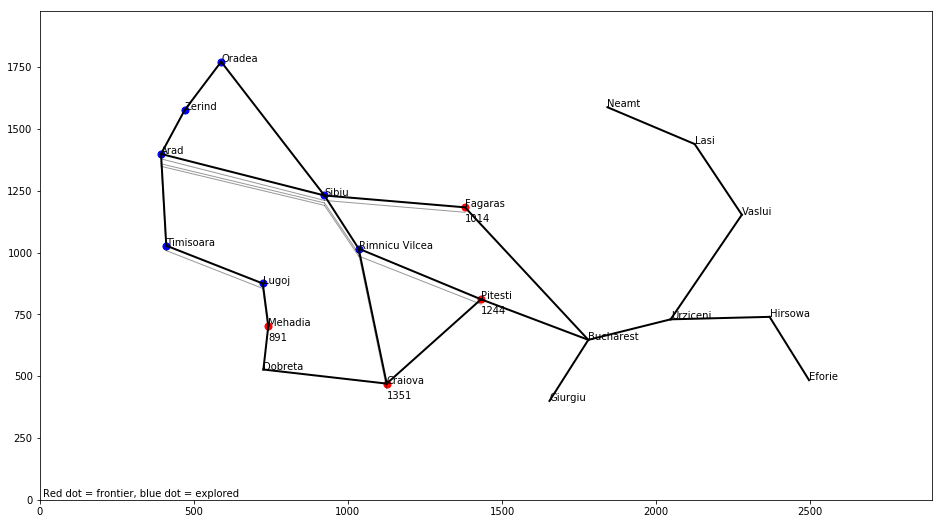

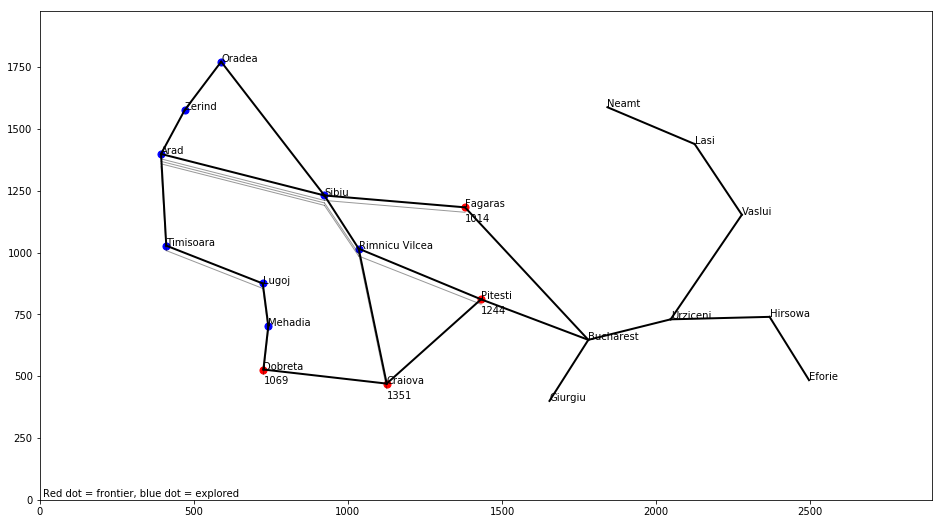

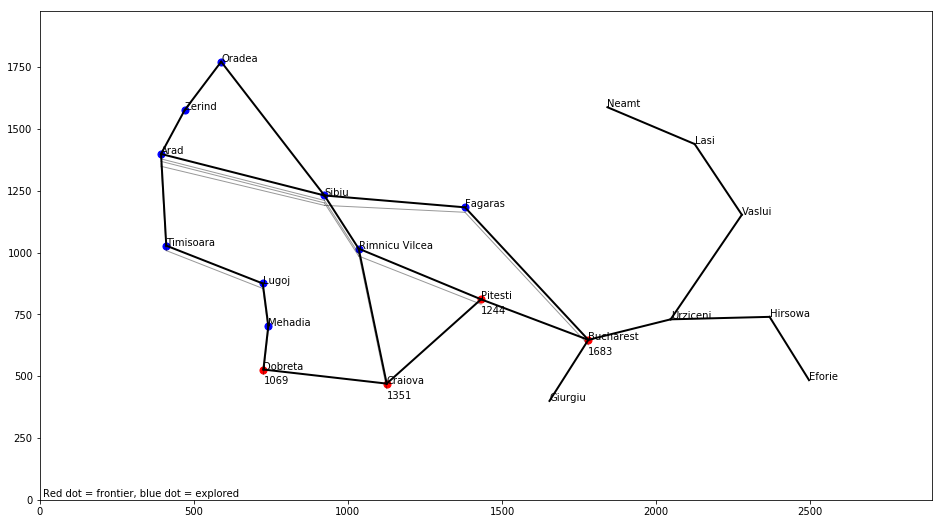

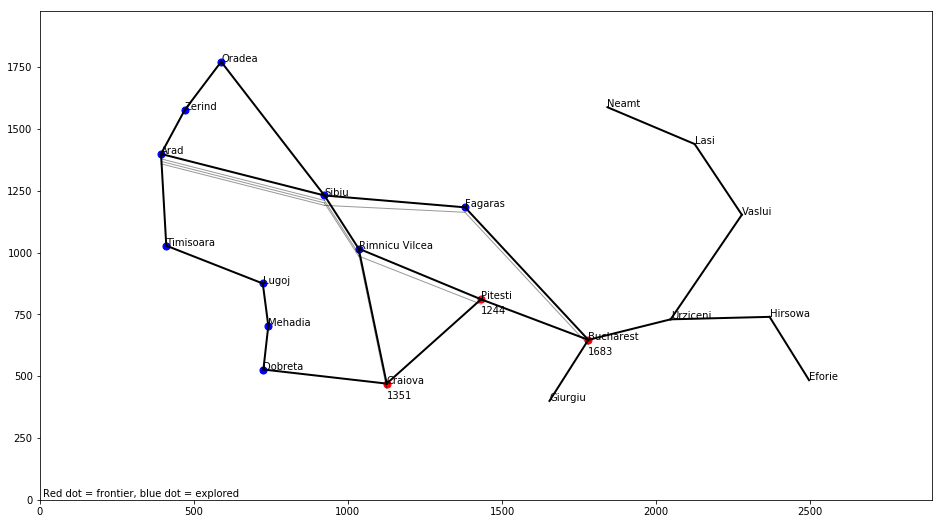

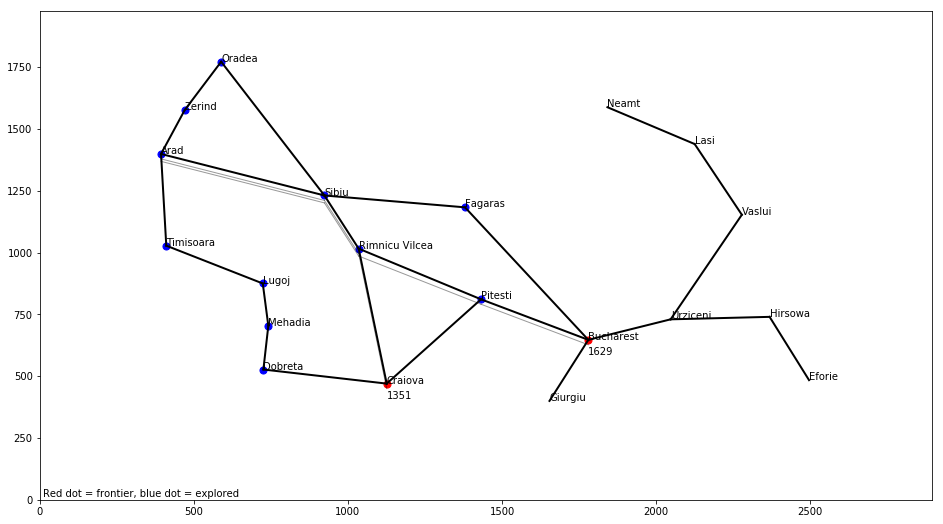

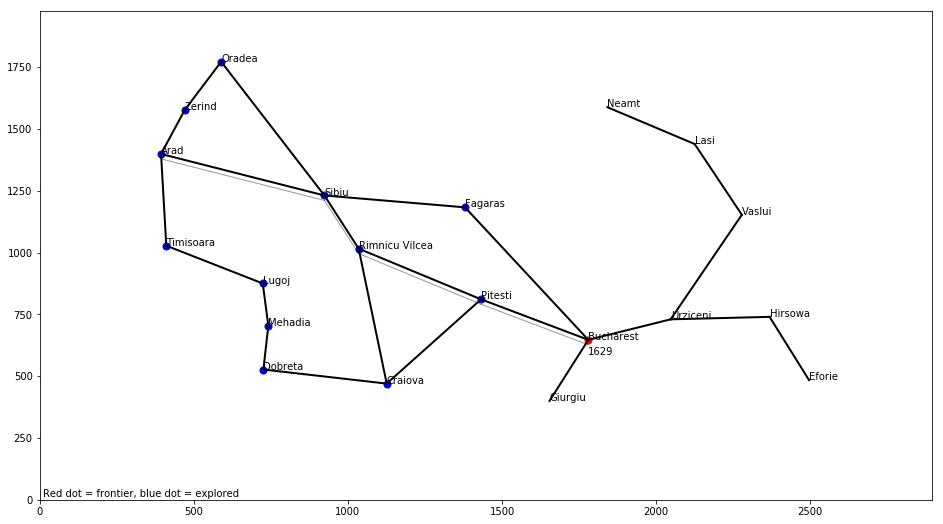

Arad->Sibiu->Rimnicu Vilcea->Pitesti->Bucharest cost: 1629


In [10]:
def uniform_cost_search(start, goal):
    global path
    frontier = [path(start)]
    explored = []
    
    if frontier[0].location == goal:
        return frontier[0]
    
    while True:
        if len(frontier) == 0:
            return False
        node = random.choice(min_objects(frontier, "cost"))
        if node.location == goal:
            return node
        
        
        frontier.remove(node)
        explored.append(node.location)
       
        for new_location in connections_from(node.location):

            if new_location in explored:
                continue
            location_in_frontier = in_objects(frontier, "location", new_location)
            if location_in_frontier == False:
                frontier.append(node.go(new_location, length_between(node.location, new_location)))
            else:
                additionaly_cost = length_between(node.location, new_location)
                if (node.cost + additionaly_cost) < location_in_frontier.cost:
                    frontier.remove(location_in_frontier)
                    frontier.append(node.go(new_location, additionaly_cost))
        
        visualizeMap(explored, frontier, 3)

                
print(uniform_cost_search("Arad", "Bucharest"))

#### A*

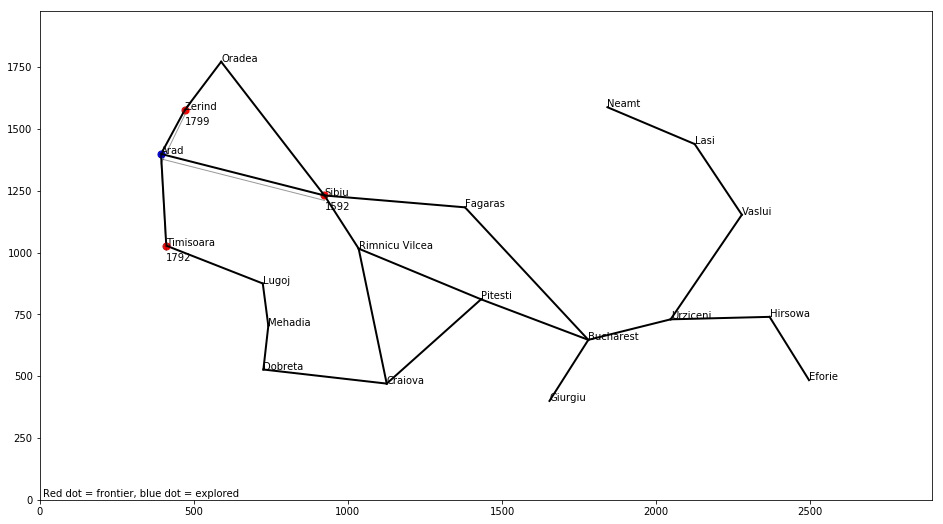

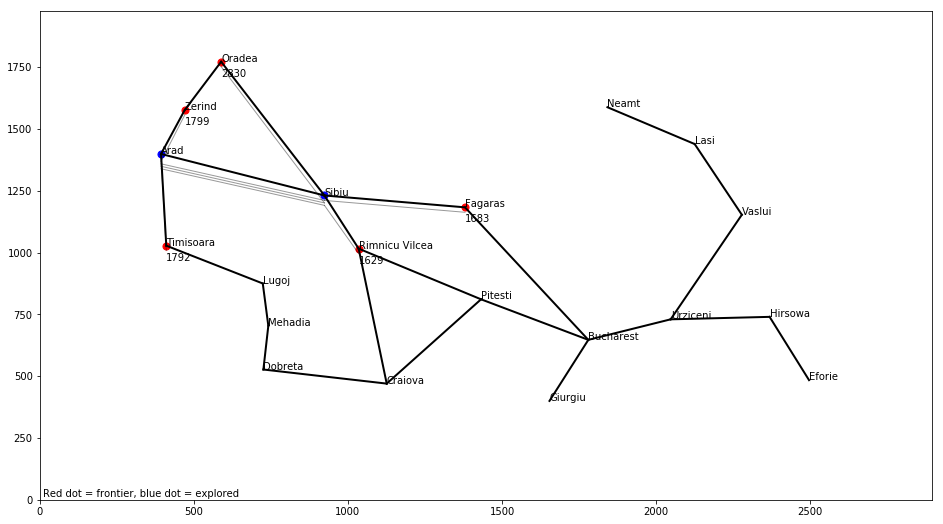

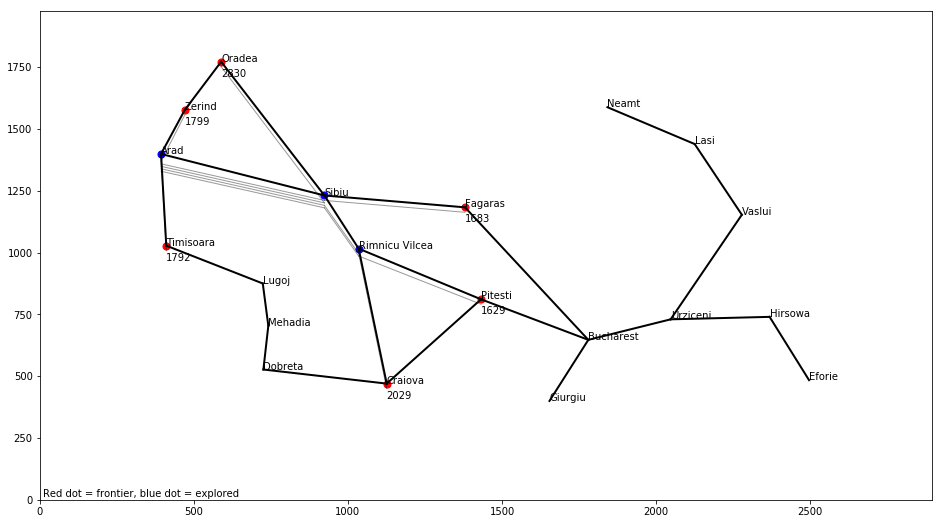

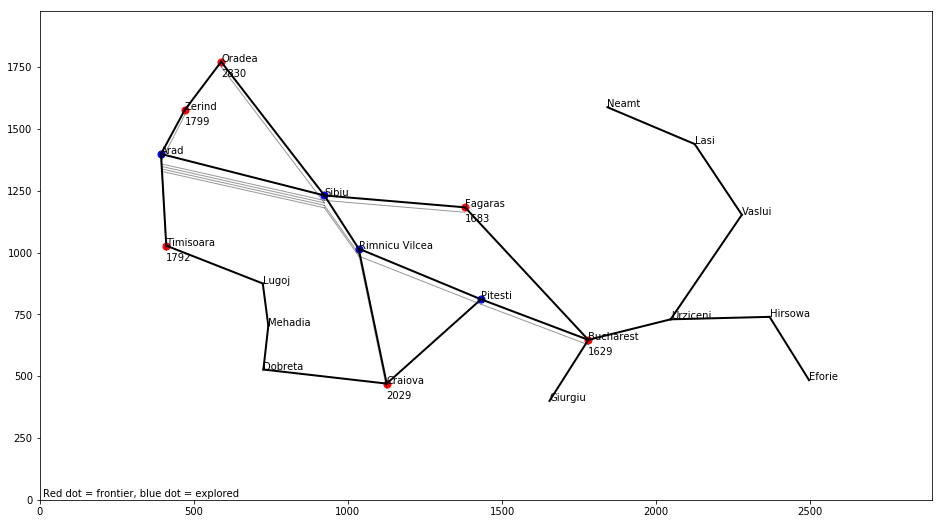

Arad->Sibiu->Rimnicu Vilcea->Pitesti->Bucharest cost: 1629


In [11]:
def a_star(start, goal):
    global path
    frontier = [path(start)]
    explored = []
    
    if frontier[0].location == goal:
        return frontier[0]
    
    while True:
        if len(frontier) == 0:
            return False
        node = random.choice(min_objects(frontier, "combined_cost"))
        if node.location == goal:
            return node
        
        frontier.remove(node)
        explored.append(node.location)
       
        for new_location in connections_from(node.location):
            if new_location in explored:
                continue
                
            new_location_frontier = node.go(new_location, length_between(node.location, new_location))
            new_location_frontier.cost_to_goal = length_between(new_location, goal)
            
            location_in_frontier = in_objects(frontier, "location", new_location)
            if location_in_frontier == False:
                frontier.append(new_location_frontier)
            else:                
                if new_location_frontier.combined_cost < location_in_frontier.combined_cost:
                    frontier.remove(location_in_frontier)
                    frontier.append(new_location_frontier) 
                    
        visualizeMap(explored, frontier, 3)
        
print(a_star("Arad", "Bucharest"))